In [1]:
import pandas as pd
import joblib
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import warnings 
warnings.simplefilter('ignore')
from torch.nn import Linear,ReLU,Sigmoid
from utils import *
torch.cuda.is_available()

True

In [2]:
tag = pd.read_csv('./data/tag盤點表_cleaned.csv')
tag_map = dict(zip(tag['TAG'],tag['chinese']))

In [3]:
critic = joblib.load('./model/net.pkl')
critic = critic.eval()
mm_x = joblib.load('./model/mm_x.pkl')
mm_y = joblib.load('./model/mm_y.pkl')

# def columns

In [4]:
x_cols = [
          'MLPAP_FR-0632.PV',
          'MLPAP_LIC-0738.PV',
          'MLPAP_LRC-0729.PV',
          'MLPAP_PIC-0761.PV',
          'MLPAP_TJ-0757B.PV',
          'MLPAP_TJC-0627.PV',
          'MLPAP_TJC-0757.PV',
          'MLPAP_TJC-0757A.PV',
          'MLPAP_TJC-1721.PV',
          'MLPAP_TRC-0610.PV',
          'MLPAP_TRC-0747.PV',
          'MLPAP_TRC-0762.PV',
          'MLPAP_TRC-1734.PV']
x_cols = sorted(x_cols)
x_cols.insert(0,'MLPAP_FQ-0619.PV')
x_cols

['MLPAP_FQ-0619.PV',
 'MLPAP_FR-0632.PV',
 'MLPAP_LIC-0738.PV',
 'MLPAP_LRC-0729.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJ-0757B.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TJC-0757.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TRC-0762.PV',
 'MLPAP_TRC-1734.PV']

In [5]:
y_cols = ['MLPAP_FQI-0997.PV']

# critic forward test

In [6]:
x = np.random.normal(loc=0,scale=1,size=(37,14))
x = pd.DataFrame(x,columns=x_cols)
x.head()

,MLPAP_FQ-0619.PV,MLPAP_FR-0632.PV,MLPAP_LIC-0738.PV,MLPAP_LRC-0729.PV,MLPAP_PIC-0761.PV,MLPAP_TJ-0757B.PV,MLPAP_TJC-0627.PV,MLPAP_TJC-0757.PV,MLPAP_TJC-0757A.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-0610.PV,MLPAP_TRC-0747.PV,MLPAP_TRC-0762.PV,MLPAP_TRC-1734.PV
0,0.916176,3.258898,0.982625,0.134906,-0.586874,0.682373,1.991272,1.979646,-0.308405,-0.228039,-1.481189,-0.112635,-0.828595,2.133079
1,-0.947830,-1.113720,-1.001749,0.692714,0.074162,1.096273,0.055831,-0.659049,-0.479979,0.667445,0.577898,-0.212198,1.407097,-0.425847
2,0.434596,0.497991,0.162956,-0.075032,-0.991120,1.288254,0.561807,-0.074982,-1.305862,-0.601079,-0.142751,0.468844,1.208378,-0.793771
3,0.729330,0.760467,-1.009298,1.002301,1.325694,1.799572,-0.446950,-0.519892,1.851007,1.454247,0.525312,-0.186029,-1.237532,-1.482692
4,0.821951,-1.053503,-0.831177,1.082099,-0.121396,1.524398,1.123348,-1.163816,-1.067848,0.161259,1.330423,0.214285,-0.155209,-0.278005


In [7]:
y = critic(torch.tensor(x.values.reshape(-1,37*14)).cuda())
print(y)
y = mm_y.inverse_transform(y.detach().cpu().numpy())
y

tensor([[0.7965]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SigmoidBackward>)


array([[8982.9220435]])

# obj_function

In [8]:
mm_y.data_min_,mm_y.data_max_

(array([5006.8877]), array([9998.904]))

In [9]:
def obj_function(x):
    # 0997 pred
    y = critic(x)
    # 還原原本區間
    y = (9998.904-5006.8877)*y + 5006.8877
    # 計算loss
    loss = ((y-8042)**2)**(0.5)
    return loss.mean()

In [10]:
x = torch.tensor(x.values.reshape(-1,37*14)).cuda()
obj_function(x)

tensor(940.9220, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)

# build generator

In [11]:
def build_generator(input_shape,output_shape):
    net = torch.nn.Sequential(
        Linear(input_shape,256),
        ReLU(),
        Linear(256,output_shape),
        Sigmoid()
    )
    return net

In [12]:
def init_weights(m):
  if hasattr(m,'weight'):
    torch.nn.init.xavier_uniform(m.weight)
  if hasattr(m,'bias'):  
    m.bias.data.fill_(0)

In [13]:
net = build_generator(1,37*14).double().cuda()
net.apply(init_weights)
net

Sequential(
  (0): Linear(in_features=1, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=518, bias=True)
  (3): Sigmoid()
)

# noise_iter

In [14]:
noise = torch.tensor(np.random.normal(loc=0,scale=1,size=(5000,1))).cuda()
noise_datasets = torch.utils.data.TensorDataset(noise)
noise_iter = torch.utils.data.DataLoader(noise_datasets,batch_size=128)
noise_iter

# obj function

In [15]:
# not maximum 0997
#obj_function = lambda x:critic(x).mean()

# optimizer

In [16]:
optimizer = optim.Adam(net.parameters(),lr=1e-4)

# train

In [17]:
def train(net,noise_iter,obj_function,optimizer,num_epochs=100):
    train_history = []
    for epoch in range(num_epochs):
        train_avg_loss = 0
        t = 0
        for noise in noise_iter:
            noise = noise[0]
            z = net(noise).cuda()
            loss = obj_function(z)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_avg_loss += loss.item()
            t += 1
        train_avg_loss /= t
        print("epochs {} loss {:.4f}".format(epoch,train_avg_loss))
        train_history.append(train_avg_loss)
    # plt train loss
    plt.plot(np.array(train_history))
    plt.title('train loss')
    # return trained net
    return net

epochs 0 loss 804.9013
epochs 1 loss 497.5380
epochs 2 loss 406.3547
epochs 3 loss 362.7877
epochs 4 loss 310.6446
epochs 5 loss 245.4625
epochs 6 loss 166.7692
epochs 7 loss 75.0928
epochs 8 loss 13.5273
epochs 9 loss 8.6142
epochs 10 loss 6.3140
epochs 11 loss 3.9502
epochs 12 loss 3.1935
epochs 13 loss 2.5455
epochs 14 loss 2.4351
epochs 15 loss 1.7317
epochs 16 loss 1.9016
epochs 17 loss 1.8240
epochs 18 loss 2.3527
epochs 19 loss 1.0996
epochs 20 loss 1.6096
epochs 21 loss 2.1131
epochs 22 loss 1.0077
epochs 23 loss 1.0891
epochs 24 loss 1.2271
epochs 25 loss 1.2966
epochs 26 loss 2.0071
epochs 27 loss 1.4365
epochs 28 loss 1.2507
epochs 29 loss 1.5776


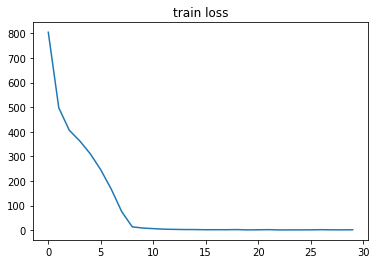

In [18]:
net = train(net,noise_iter,obj_function,optimizer,num_epochs=30)

# result

In [19]:
output = critic(net(noise)).detach().cpu().numpy()
output = mm_y.inverse_transform(output)
output = pd.DataFrame(output,columns=['0997'])
output

,0997
0,8044.076627
1,8044.167682
2,8044.120434
3,8041.285089
4,8043.083117
...,...
4995,8044.120193
4996,8044.206938
4997,8042.212700
4998,8044.096288


In [20]:
best_idx = np.argmax(output.values)
output.loc[[best_idx]]

,0997
265,8080.585079


In [21]:
result = pd.DataFrame(net(noise).detach().cpu().numpy())
result[:] = mm_x.inverse_transform(result)
r1 = result.iloc[best_idx,:].values.reshape(37,14)
r1 = pd.DataFrame(r1,columns=x_cols)
r1.loc['median'] = r1.median(axis=0)
r1

,MLPAP_FQ-0619.PV,MLPAP_FR-0632.PV,MLPAP_LIC-0738.PV,MLPAP_LRC-0729.PV,MLPAP_PIC-0761.PV,MLPAP_TJ-0757B.PV,MLPAP_TJC-0627.PV,MLPAP_TJC-0757.PV,MLPAP_TJC-0757A.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-0610.PV,MLPAP_TRC-0747.PV,MLPAP_TRC-0762.PV,MLPAP_TRC-1734.PV
0,6257.127322,76.098573,40.858513,42.568938,49.308096,354.434991,149.275013,0.113106,353.128494,61.197381,177.699223,171.985991,357.711783,181.338678
1,6222.094735,75.781923,37.083640,45.068441,49.258488,354.628233,148.993721,0.003493,354.410314,61.468382,177.825440,171.746671,357.140717,180.281171
2,5917.802201,76.124391,43.735881,44.978217,49.315438,355.302147,150.821363,0.121139,352.063437,62.153766,177.271005,171.154396,356.691180,179.292115
3,6281.744836,75.950185,44.188816,41.317949,49.268968,354.856754,149.521392,0.379088,354.069521,60.913856,177.135785,171.409703,357.348516,179.107360
4,5861.829059,76.049411,45.143365,43.221224,49.289254,354.389916,150.076840,0.105417,352.739526,60.674534,180.252184,172.498531,355.794939,176.071671
5,6480.248699,75.619448,44.144196,45.635616,49.251073,353.559236,151.134427,0.097824,353.167910,61.315249,177.638695,170.544078,356.595231,181.878450
6,6022.787437,75.996909,44.549970,44.756199,49.306176,353.250562,149.799015,0.738580,355.363234,61.003561,175.514469,171.257850,356.897435,181.391140
7,6420.738228,75.602644,44.459279,41.834882,49.279380,353.440838,150.694782,0.292569,353.490556,61.259241,175.881209,171.511341,356.048987,178.593256
8,6028.208764,74.868056,44.775147,46.151340,49.182858,354.788909,150.291328,0.408291,353.339301,61.267545,178.910405,171.923080,356.914491,180.720180
9,6374.023126,75.040957,45.559734,45.159243,49.194321,353.841178,150.467517,0.770652,352.519917,60.660385,175.552990,170.555990,358.535088,180.138544


In [22]:
r1 = r1.loc[['median']].T
r1['chinese'] = r1.index.map(tag_map)
r1 = r1[['chinese','median']]

In [23]:
print('best control factor maybe:')
r1

best control factor maybe:


,chinese,median
MLPAP_FQ-0619.PV,OX入料量,6281.744836
MLPAP_FR-0632.PV,汽機風量,75.834918
MLPAP_LIC-0738.PV,汽鼓(V211)鍋爐水液位,44.144196
MLPAP_LRC-0729.PV,鍋爐水液位控制,44.017468
MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,49.266767
MLPAP_TJ-0757B.PV,反應槽鹽浴溫度,354.031553
MLPAP_TJC-0627.PV,OX預熱器出口溫度,150.246834
MLPAP_TJC-0757.PV,反應器A/B側鹽浴溫度差,0.379088
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,353.339301
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,61.187474


In [25]:
r1.iloc[0,1]/output.loc[[best_idx]]

,0997
265,0.777387
